In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install sickit-learn
%pip install imbalanced-learn

In [27]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Download latest version
path = kagglehub.dataset_download("valakhorasani/electric-vehicle-charging-patterns")
file_path = os.path.join(path, "ev_charging_patterns.csv")

df = pd.read_csv(file_path)

print(f"Numero di righe nel dataset: {df.shape[0]}")

df.head()

Numero di righe nel dataset: 1320


,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


# Ridenominazione colonne

In [ ]:
# Rinominare le colonne
df = df.rename(columns={
    'User ID': 'user_id',
    'Vehicle Model': 'vehicle_model',
    'Battery Capacity (kWh)': 'battery_capacity_kwh',
    'Charging Station ID': 'station_id',
    'Charging Station Location': 'station_location',
    'Charging Start Time': 'start_time',
    'Charging End Time': 'end_time',
    'Energy Consumed (kWh)': 'energy_consumed_kwh',
    'Charging Duration (hours)': 'duration_hours',
    'Charging Rate (kW)': 'rate_kw',
    'Charging Cost (USD)': 'cost_usd',
    'Time of Day': 'time_of_day',
    'Day of Week': 'day_of_week',
    'State of Charge (Start %)': 'soc_start_percent',
    'State of Charge (End %)': 'soc_end_percent',
    'Distance Driven (since last charge) (km)': 'distance_km',
    'Temperature (°C)': 'temperature_c',
    'Vehicle Age (years)': 'vehicle_age_years',
    'Charger Type': 'charger_type',
    'User Type': 'user_type'
})

# Visualizzare il dataset trasformato
df.head()

Numero di righe nel dataset senza valori nulli: 1320


,user_id,vehicle_model,battery_capacity_kwh,station_id,station_location,start_time,end_time,energy_consumed_kwh,duration_hours,rate_kw,cost_usd,time_of_day,day_of_week,soc_start_percent,soc_end_percent,distance_km,temperature_c,vehicle_age_years,charger_type,user_type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [ ]:
print(df['user_id'].is_unique)

### Verifica dei valori nulli

In [32]:
print(f"Numero di righe nel dataset senza valori nulli: {df.shape[0]}")

df.isnull().sum()

Numero di righe nel dataset senza valori nulli: 1320


user_id                 0
vehicle_model           0
battery_capacity_kwh    0
station_id              0
station_location        0
start_time              0
end_time                0
energy_consumed_kwh     0
duration_hours          0
rate_kw                 0
cost_usd                0
time_of_day             0
day_of_week             0
soc_start_percent       0
soc_end_percent         0
distance_km             0
temperature_c           0
vehicle_age_years       0
charger_type            0
user_type               0
dtype: int64

# Rimozione valori nulli (interi record)

In [3]:
# Rimuovere i valori nulli (elimina intero record = riga)
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")

Numero di righe nel dataset senza valori nulli: 1131


# Trasformazione dei dati numerici
Data la scarsa quantità di dati, piuttosto che eliminare i valori nulli, tramite l'oggetto _Pipeline_, è possibile riempire i valori mancanti nei dati numerici utilizzando il metodo **K-Nearest Neighbors (KNN)**.

In [33]:
columns_with_nulls = ['energy_consumed_kwh', 'rate_kw', 'distance_km']

numeric_transformer= Pipeline([
    ('knn_imputer', KNNImputer(weights='distance')),
    ('power_transformer', PowerTransformer())
])

transformed_data = numeric_transformer.fit_transform(df[columns_with_nulls])

df_cleaned = pd.DataFrame(transformed_data, columns=columns_with_nulls, index=df.index)
df[columns_with_nulls] = df_cleaned

print(f"Numero di righe nel dataset dopo la pipeline: {df_cleaned.shape[0]}")

df.isnull().sum()

Numero di righe nel dataset dopo la pipeline: 1320


user_id                 0
vehicle_model           0
battery_capacity_kwh    0
station_id              0
station_location        0
start_time              0
end_time                0
energy_consumed_kwh     0
duration_hours          0
rate_kw                 0
cost_usd                0
time_of_day             0
day_of_week             0
soc_start_percent       0
soc_end_percent         0
distance_km             0
temperature_c           0
vehicle_age_years       0
charger_type            0
user_type               0
dtype: int64

## Cambio di indice del dataframe
Si può accedere ad ogni record specifico tramite il metodo loc[].

In [34]:
df = df.set_index('user_id') # Setto la colonna user_id come indice
df.head()

,vehicle_model,battery_capacity_kwh,station_id,station_location,start_time,end_time,energy_consumed_kwh,duration_hours,rate_kw,cost_usd,time_of_day,day_of_week,soc_start_percent,soc_end_percent,distance_km,temperature_c,vehicle_age_years,charger_type,user_type
user_id,,,,,,,,,,,,,,,,,,,
User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,0.824218,0.591363,0.773711,13.087717,Evening,Tuesday,29.371576,86.119962,1.598879,27.947953,2.0,DC Fast Charger,Commuter
User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,-1.385901,3.133652,0.394654,21.128448,Morning,Monday,10.115778,84.664344,-0.438661,14.311026,3.0,Level 1,Casual Driver
User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,-1.045568,2.452653,0.177810,35.667270,Morning,Thursday,6.854604,69.917615,-0.931085,21.002002,2.0,Level 2,Commuter
User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,1.641273,1.266431,0.542820,13.036239,Evening,Saturday,83.120003,99.624328,0.564362,38.316313,1.0,Level 1,Long-Distance Traveler
User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,-1.021471,2.019765,-1.148591,10.161471,Morning,Saturday,54.258950,63.743786,0.610279,-7.834199,1.0,Level 1,Long-Distance Traveler


In [36]:
df.loc['User_3']

vehicle_model                    Chevy Bolt
battery_capacity_kwh                   75.0
station_id                      Station_181
station_location              San Francisco
start_time              2024-01-01 02:00:00
end_time                2024-01-01 04:48:00
energy_consumed_kwh               -1.045568
duration_hours                     2.452653
rate_kw                             0.17781
cost_usd                           35.66727
time_of_day                         Morning
day_of_week                        Thursday
soc_start_percent                  6.854604
soc_end_percent                   69.917615
distance_km                       -0.931085
temperature_c                     21.002002
vehicle_age_years                       2.0
charger_type                        Level 2
user_type                          Commuter
Name: User_3, dtype: object

# Classificazione
Creazione di un **modello predittivo** per classificare gli utenti in base al loro comportamento di ricarica

In [37]:
# Feature Engineering
df['start_hour'] = pd.to_datetime(df['start_time']).dt.hour
df['time_of_day'] = df['time_of_day'].astype('category').cat.codes

# Seleziona le variabili rilevanti
features = ['start_hour', 'duration_hours', 'time_of_day', 'energy_consumed_kwh']
X_initial = df[features]

# Crea etichette basate su regole di classificazione
def classify_user(row):
    if row['duration_hours'] > 3 and row['energy_consumed_kwh'] > 50:
        return 'utenti intensivi'
    elif row['duration_hours'] > 1:
        return 'utenti frequenti'
    else:
        return 'utenti occasionali'

df['user_type'] = df.apply(classify_user, axis=1)

# Codifica la variabile target
label_encoder = LabelEncoder()
# 0: utenti intensivi, 1: utenti frequenti, 2: utenti occasionali
y = label_encoder.fit_transform(df['user_type'])

X_initial['user_type'] = df['user_type']

X_initial.head()

,start_hour,duration_hours,time_of_day,energy_consumed_kwh,user_type
user_id,,,,,
User_1,0,0.591363,1,0.824218,utenti occasionali
User_2,1,3.133652,2,-1.385901,utenti frequenti
User_3,2,2.452653,2,-1.045568,utenti frequenti
User_4,3,1.266431,1,1.641273,utenti frequenti
User_5,4,2.019765,2,-1.021471,utenti frequenti


## Normalizzazione delle feature numeriche

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Identificazione delle colonne numeriche
numerical_columns = X_initial.select_dtypes(include=['float64', 'int64']).columns

# Inizializzazione del MinMaxScaler
scaler = MinMaxScaler()

# Applicazione del MinMaxScaler ai valori numerici
X_initial[numerical_columns] = scaler.fit_transform(X_initial[numerical_columns])

print("\nDataset normalizzato (Min-Max Scaling):")
X_initial.head()


Dataset normalizzato (Min-Max Scaling):


,start_hour,duration_hours,time_of_day,energy_consumed_kwh,user_type
user_id,,,,,
User_1,0,0.065790,1,0.398616,utenti occasionali
User_2,1,0.402972,2,0.080776,utenti frequenti
User_3,2,0.312651,2,0.125388,utenti frequenti
User_4,3,0.155324,1,0.521785,utenti frequenti
User_5,4,0.255238,2,0.128674,utenti frequenti


In [10]:
from sklearn.preprocessing import LabelEncoder

'''
0 -> utenti frequenti
1 -> utenti intensivi
2 -> utenti occasionali
'''

# Codifica 'user_type' in numerico (0, 1, 2)
label_encoder = LabelEncoder()
X_initial['user_type_encoded'] = label_encoder.fit_transform(X_initial['user_type'])

# Aggiungi la colonna numerica a X
X_initial = X_initial.copy()  # Per evitare modifiche accidentali a X originale
X_initial['user_type'] = X_initial['user_type_encoded']

# Verifica le modifiche
X_initial.head()


,start_hour,duration_hours,time_of_day,energy_consumed_kwh,user_type,user_type_encoded
user_id,,,,,,
User_1,0,0.065790,1,0.398616,2,2
User_2,1,0.402972,2,0.080776,0,0
User_3,2,0.312651,2,0.125388,0,0
User_4,3,0.155324,1,0.521785,0,0
User_5,4,0.255238,2,0.128674,0,0


## Bilanciamento del dataset

In [11]:
user_type_counts = X_initial['user_type'].value_counts()

print("Conteggio delle righe per ciascun codice di pagamento:")
print(user_type_counts)

Conteggio delle righe per ciascun codice di pagamento:
user_type
0    832
2    156
1    143
Name: count, dtype: int64


## Correlazione tra le feature
Si evince dalla heatmap generata nel codice sottostante come non siano presenti, tra le feature scelte per la classificazione, delle correlazioni. 

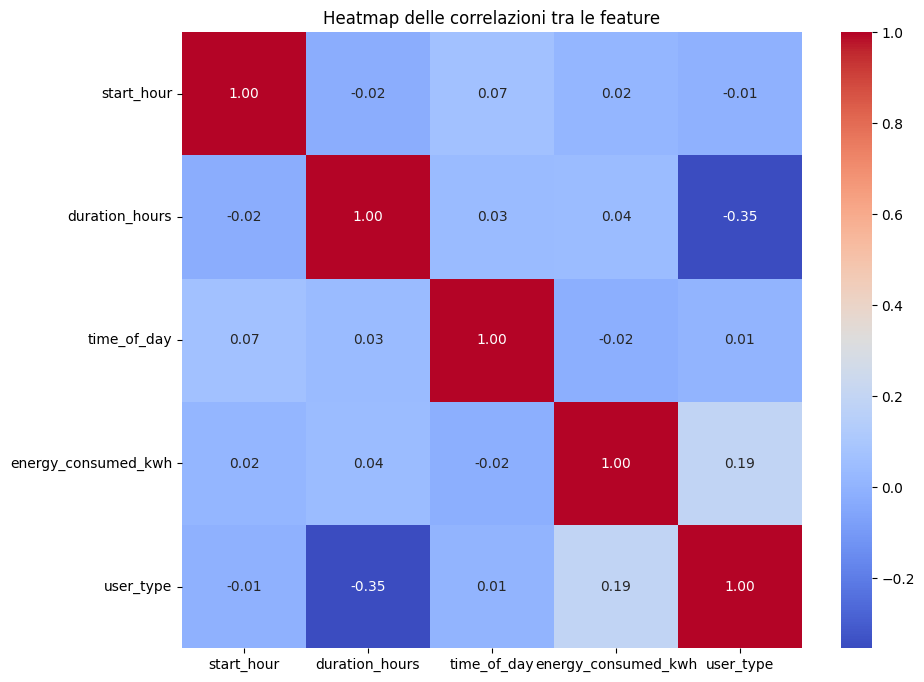

In [12]:
X_initial['user_type_encoded'] = y

correlation_features = X_initial.copy()
correlation_features['user_type_encoded'] = y

correlation_features = correlation_features.drop(columns=['user_type_encoded'], errors='ignore')

correlation_matrix = correlation_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap delle correlazioni tra le feature")
plt.show()

## Holdout con oversampling

1131
Distribuzione delle classi prima di SMOTE: Counter({0: 582, 2: 109, 1: 100})
Distribuzione delle classi dopo SMOTE: Counter({0: 832, 1: 832, 2: 832})
Training Accuracy: 99.72%
Testing Accuracy: 99.41%

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       250
           1       1.00      0.95      0.98        43
           2       1.00      1.00      1.00        47

    accuracy                           0.99       340
   macro avg       1.00      0.98      0.99       340
weighted avg       0.99      0.99      0.99       340



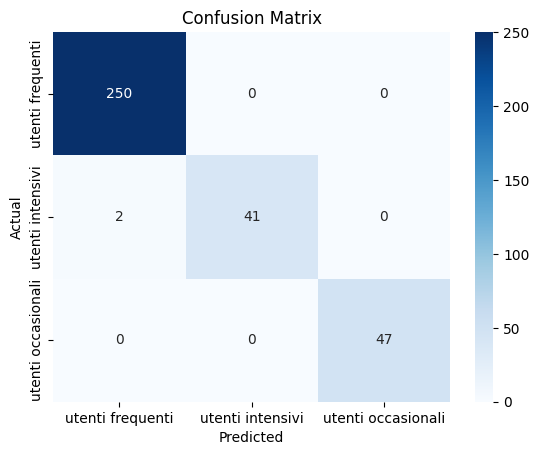

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Dividi il dataset in feature (X) e target (y)
X = X_initial.drop(columns=['user_type_encoded', 'user_type'])  # Escludi la variabile target
y = X_initial['user_type']  # Variabile target

print(X_initial.shape[0])

# Suddivisione in train e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Applica SMOTE al training set
smote = SMOTE(sampling_strategy={0: 832, 1: 832, 2: 832}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifica la distribuzione delle classi dopo SMOTE
print(f"Distribuzione delle classi prima di SMOTE: {Counter(y_train)}")
print(f"Distribuzione delle classi dopo SMOTE: {Counter(y_train_resampled)}")

# Addestra un modello Random Forest sul dataset bilanciato
model = RandomForestClassifier(
    class_weight=None,  # Rimuoviamo class_weight perché SMOTE bilancia già i dati
    n_estimators=200,
    max_depth=100,
    min_samples_leaf=40,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_resampled, y_train_resampled)

# Valutazione sul training set
y_train_pred = model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Valutazione sul test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Report di classificazione
print("\nClassification Report (Testing Set):")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## K fold con Random Forest

Fold 1
Distribuzione delle classi prima di SMOTE: Counter({0: 756, 2: 133, 1: 128})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.96%
Testing Accuracy: 99.12%


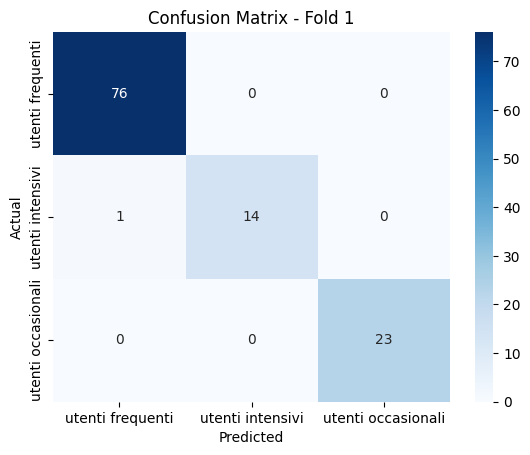

Fold 2
Distribuzione delle classi prima di SMOTE: Counter({0: 748, 2: 138, 1: 132})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 100.00%
Testing Accuracy: 100.00%


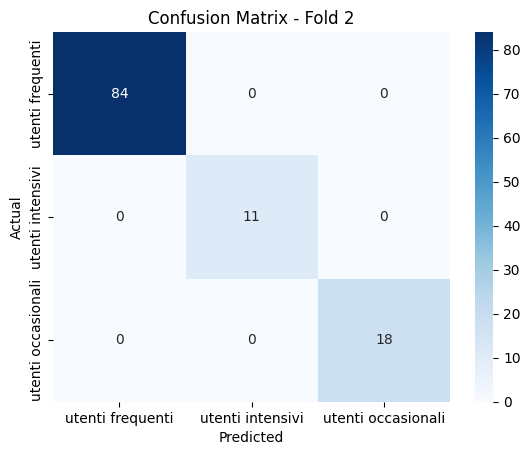

Fold 3
Distribuzione delle classi prima di SMOTE: Counter({0: 752, 2: 141, 1: 125})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.84%
Testing Accuracy: 99.12%


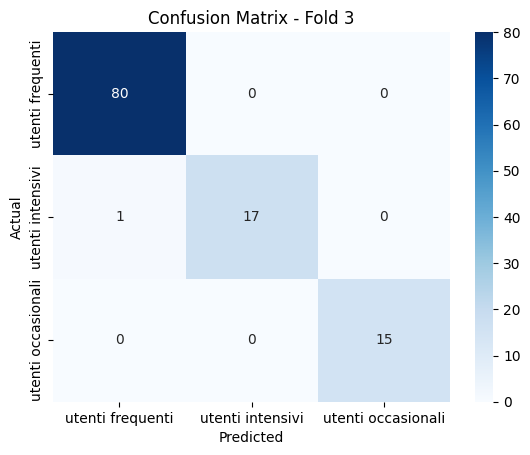

Fold 4
Distribuzione delle classi prima di SMOTE: Counter({0: 751, 2: 144, 1: 123})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.96%
Testing Accuracy: 100.00%


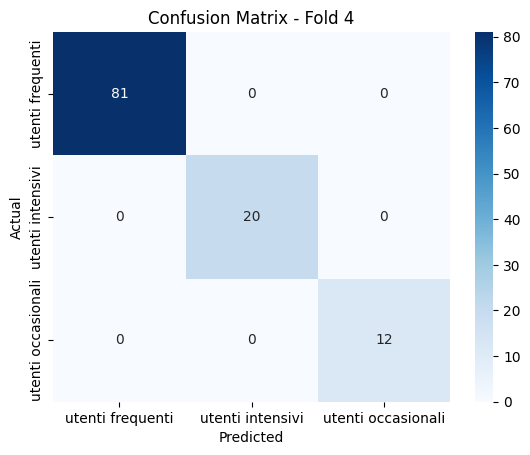

Fold 5
Distribuzione delle classi prima di SMOTE: Counter({0: 749, 2: 140, 1: 129})
Distribuzione delle classi dopo SMOTE: Counter({0: 832, 2: 832, 1: 832})
Training Accuracy: 99.96%
Testing Accuracy: 99.12%


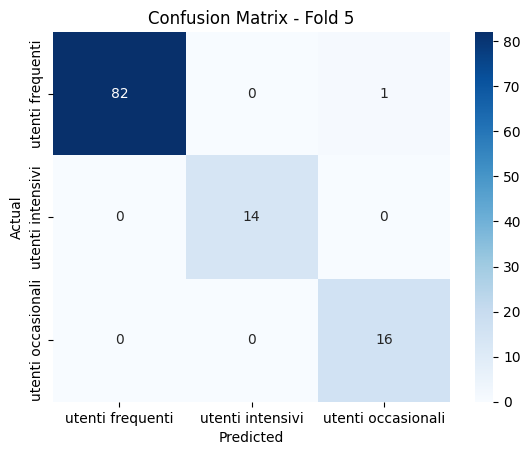

Fold 6
Distribuzione delle classi prima di SMOTE: Counter({0: 751, 2: 138, 1: 129})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.92%
Testing Accuracy: 100.00%


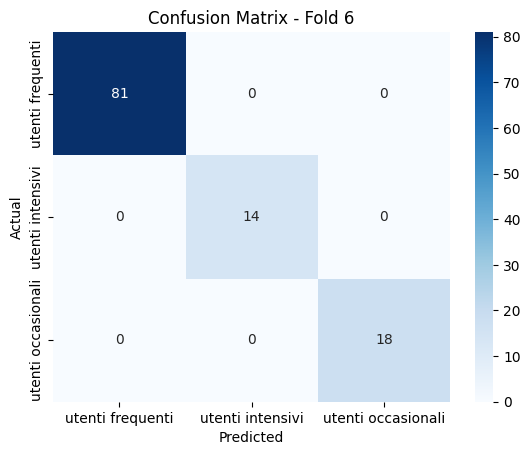

Fold 7
Distribuzione delle classi prima di SMOTE: Counter({0: 742, 2: 146, 1: 130})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 100.00%
Testing Accuracy: 100.00%


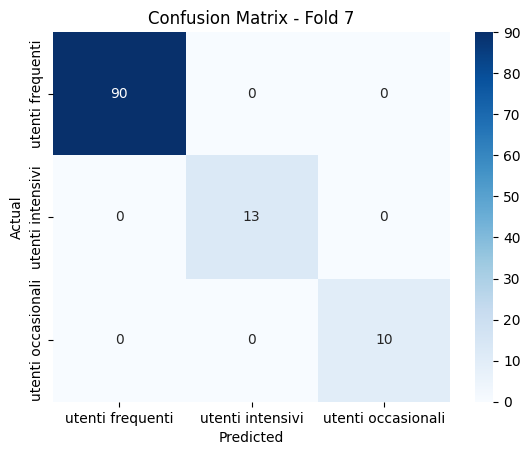

Fold 8
Distribuzione delle classi prima di SMOTE: Counter({0: 746, 2: 139, 1: 133})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.88%
Testing Accuracy: 100.00%


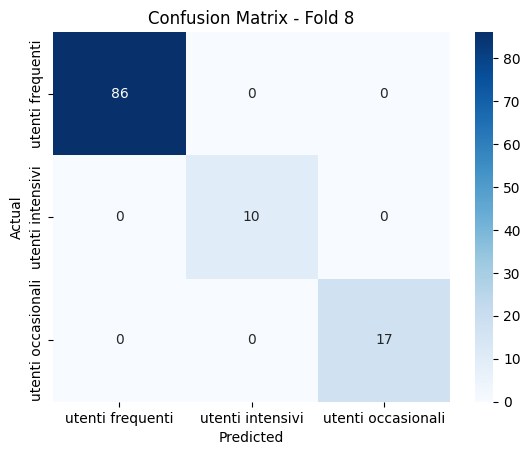

Fold 9
Distribuzione delle classi prima di SMOTE: Counter({0: 745, 2: 141, 1: 132})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.80%
Testing Accuracy: 100.00%


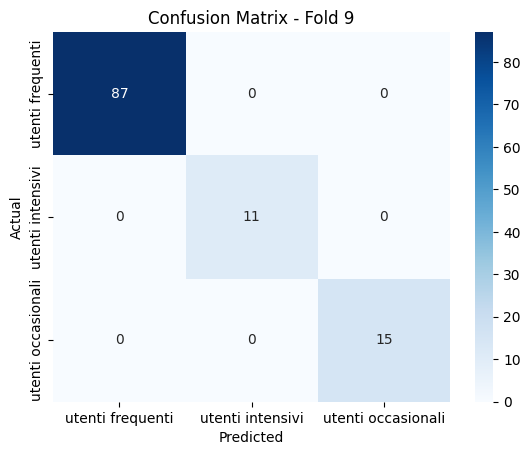

Fold 10
Distribuzione delle classi prima di SMOTE: Counter({0: 748, 2: 144, 1: 126})
Distribuzione delle classi dopo SMOTE: Counter({2: 832, 0: 832, 1: 832})
Training Accuracy: 99.80%
Testing Accuracy: 99.12%


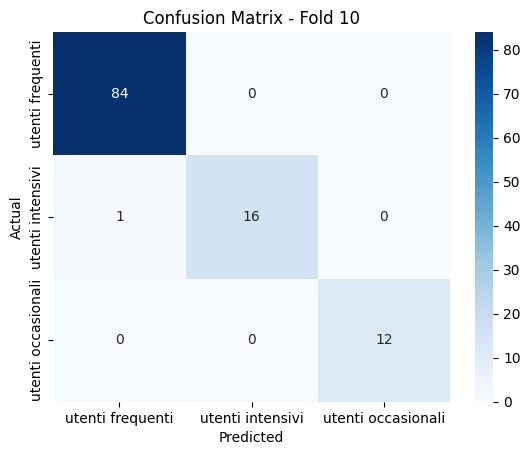


--- Risultati finali ---
Training Accuracy: Mean = 99.91%, Std Dev = 0.07%
Testing Accuracy: Mean = 99.65%, Std Dev = 0.43%


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Dividi il dataset in feature (X) e target (y)
X = X_initial.drop(columns=['user_type_encoded', 'user_type'])  # Escludi la variabile target
y = X_initial['user_type']  # Variabile target

# Configura Stratified K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Variabili per raccogliere le metriche
train_accuracies = []
test_accuracies = []
classification_reports = []
confusion_matrices = []

# Loop sui fold
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}")
    
    # Suddividi i dati
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Applica SMOTE al training set
    smote = SMOTE(sampling_strategy={0: 832, 1: 832, 2: 832}, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Verifica la distribuzione delle classi dopo SMOTE
    print(f"Distribuzione delle classi prima di SMOTE: {Counter(y_train)}")
    print(f"Distribuzione delle classi dopo SMOTE: {Counter(y_train_resampled)}")

    # Addestra il modello
    model = RandomForestClassifier(
        class_weight=None,  # Rimuoviamo class_weight perché SMOTE bilancia già i dati
        n_estimators=200,
        max_depth=100,
        min_samples_leaf=40,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_resampled, y_train_resampled)

    # Valutazione sul training set
    y_train_pred = model.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_accuracies.append(train_accuracy)
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

    # Valutazione sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    # Report di classificazione e matrice di confusione
    classification_reports.append(classification_report(y_test, y_test_pred))
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    confusion_matrices.append(conf_matrix)

    # Stampa matrice di confusione
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

# Report finale
print("\n--- Risultati finali ---")
print(f"Training Accuracy: Mean = {np.mean(train_accuracies) * 100:.2f}%, Std Dev = {np.std(train_accuracies) * 100:.2f}%")
print(f"Testing Accuracy: Mean = {np.mean(test_accuracies) * 100:.2f}%, Std Dev = {np.std(test_accuracies) * 100:.2f}%")


## Holdout con oversampling e decision tree

Distribuzione delle classi prima di SMOTE: Counter({0: 582, 2: 109, 1: 100})
Distribuzione delle classi dopo SMOTE: Counter({0: 582, 1: 582, 2: 582})
Training Accuracy: 100.00%
Testing Accuracy: 100.00%

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        47

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



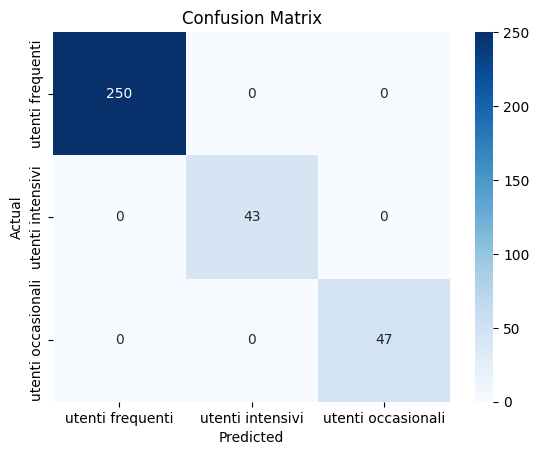

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Suddivisione in train e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Applica SMOTE al training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifica la distribuzione delle classi dopo SMOTE
print(f"Distribuzione delle classi prima di SMOTE: {Counter(y_train)}")
print(f"Distribuzione delle classi dopo SMOTE: {Counter(y_train_resampled)}")

# Addestra un modello Decision Tree sul dataset bilanciato
model = DecisionTreeClassifier(
    max_depth=100,  # Limita la profondità dell'albero
    min_samples_leaf=20,  # Numero minimo di campioni richiesti in una foglia
    random_state=42  # Per la riproducibilità
)
model.fit(X_train_resampled, y_train_resampled)

# Valutazione sul training set
y_train_pred = model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Valutazione sul test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Report di classificazione
print("\nClassification Report (Testing Set):")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Boostrap con core max

In [52]:
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tqdm import tqdm

# Parametri del bootstrap
n_iterations = 1000  # Numero di iterazioni bootstrap
train_fraction = 0.3  # Percentuale di dati nel training set
n_jobs = -1  # Numero di processori da utilizzare (-1 per tutti disponibili)

# Funzione per una singola iterazione bootstrap
def bootstrap_iteration(i, X, y, train_fraction):
    # Campionamento con sostituzione
    train_size = int(len(X) * train_fraction)
    bootstrap_indices = np.random.choice(range(len(X)), size=train_size, replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))

    # Crea training e test set
    X_train = X.iloc[bootstrap_indices]
    y_train = y[bootstrap_indices]
    X_test = X.iloc[oob_indices]
    y_test = y[oob_indices]

    # Modello Random Forest
    model = RandomForestClassifier(
        class_weight="balanced",
        n_estimators=50,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1  # Parallelizza internamente il modello
    )
    model.fit(X_train, y_train)

    # Valutazione sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Valutazione sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Log accuracies
    print(f"Iterazione {i + 1}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return train_accuracy, test_accuracy

# Esegui il bootstrap in parallelo
results = Parallel(n_jobs=n_jobs)(
    delayed(bootstrap_iteration)(i, X, y, train_fraction) for i in tqdm(range(n_iterations), desc="Bootstrap")
)

# Estrai train_accuracy e test_accuracy dai risultati
train_accuracies, test_accuracies = zip(*results)

# Calcola statistiche finali
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)
std_train_accuracy = np.std(train_accuracies)
std_test_accuracy = np.std(test_accuracies)

print("\nStatistiche finali:")
print(f"Train Accuracy: Mean = {mean_train_accuracy:.4f}, Std Dev = {std_train_accuracy:.4f}")
print(f"Test Accuracy: Mean = {mean_test_accuracy:.4f}, Std Dev = {std_test_accuracy:.4f}")


Bootstrap: 100%|██████████| 1000/1000 [00:19<00:00, 51.43it/s]



Statistiche finali:
Train Accuracy: Mean = 0.9999, Std Dev = 0.0004
Test Accuracy: Mean = 0.9928, Std Dev = 0.0056


## Versione originale

In [21]:
# Impostazioni del bootstrap
n_iterations = 10000000  # Numero di campioni bootstrap
checkpoint_interval = 100000  # Numero di iterazioni tra i checkpoint
checkpoint_file = "bootstrap_checkpoint.pkl"  # Nome file per il checkpoint

# Inizializza variabili
metrics = []
start_iteration = 0
train_fraction = 0.3

# Carica il checkpoint, se esiste
'''if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "rb") as f:
        checkpoint = pickle.load(f)
        start_iteration = checkpoint.get("iteration", -1) + 1
        metrics = checkpoint.get("metrics", [])
        print(f"Checkpoint caricato: Iterazione {start_iteration}")
else:
    print("Nessun checkpoint trovato. Inizio da zero.")'''


for i in tqdm(range(start_iteration, n_iterations), desc="Esecuzione Bootstrap"):
    # Campionamento con sostituzione
    train_size = int(len(X) * train_fraction)
    bootstrap_indices = np.random.choice(range(len(X)), size=train_size, replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))
    
    # Crea training e test set
    X_train = X.iloc[bootstrap_indices]
    y_train = y[bootstrap_indices]
    X_test = X.iloc[oob_indices]
    y_test = y[oob_indices]

    # Addestra un Random Forest Classifier
model = RandomForestClassifier(
    class_weight="balanced", # Bilancia le classi
    n_estimators=50, # Numero di alberi nella foresta
    max_depth=10, # Profondità massima dell'albero
    min_samples_leaf=5, # Numero minimo di campioni richiesti per essere in un nodo foglia (almeno 20)
    random_state=42 # Seed per la riproducibilità
    )
model.fit(X_train, y_train)

# Valuta il modello sulla fase di training
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Valuta il modello sulla fase di testing
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Stampa le accuracy
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Salva il checkpoint ogni `checkpoint_interval` iterazioni
if (i + 1) % checkpoint_interval == 0 or (i + 1) == n_iterations:
    checkpoint = {
        "iteration": i,
        "metrics": metrics
    }
    with open(checkpoint_file, "wb") as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint salvato all'iterazione {i + 1}")

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Report finale
print(f"Bootstrap Accuracy: Mean = {np.mean(metrics):.2f}, Std Dev = {np.std(metrics):.2f}")

Esecuzione Bootstrap:   5%|▍         | 473586/10000000 [03:37<1:12:46, 2181.46it/s]


KeyboardInterrupt: 

In [10]:
# Addestra un Random Forest Classifier
model = RandomForestClassifier(
    class_weight="balanced", # Bilancia le classi
    n_estimators=50, # Numero di alberi nella foresta
    max_depth=10, # Profondità massima dell'albero
    min_samples_leaf=5, # Numero minimo di campioni richiesti per essere in un nodo foglia (almeno 20)
    random_state=42 # Seed per la riproducibilità
    )
model.fit(X_train, y_train)

# Valuta il modello sulla fase di training
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Valuta il modello sulla fase di testing
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Stampa le accuracy
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Salva il checkpoint ogni `checkpoint_interval` iterazioni
if (i + 1) % checkpoint_interval == 0 or (i + 1) == n_iterations:
    checkpoint = {
        "iteration": i,
        "metrics": metrics
    }
    with open(checkpoint_file, "wb") as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint salvato all'iterazione {i + 1}")

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Report finale
print(f"Bootstrap Accuracy: Mean = {np.mean(metrics):.2f}, Std Dev = {np.std(metrics):.2f}")

NameError: name 'X_train' is not defined

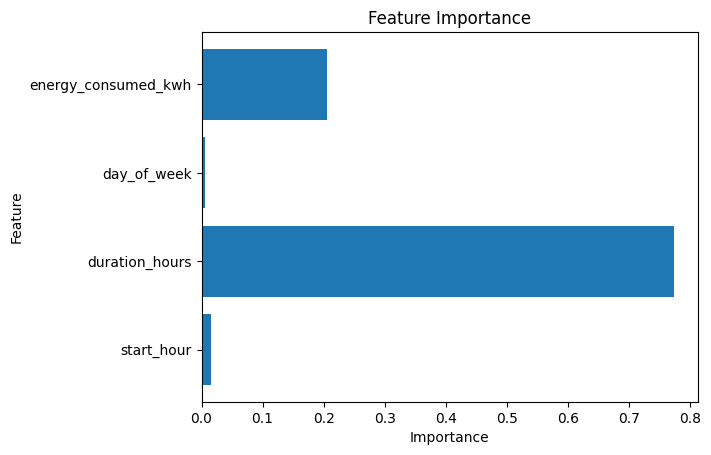

In [18]:
# Importanza delle feature
importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Regressione
- Obiettivo 1: stimare la durata della sessione di ricarica in funzione di caratteristiche come il giorno della settimana, l’orario di inizio e l’energia consumata.
- Obiettivo 2: Prevedere il consumo energetico totale basandosi sulle stesse variabili.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepara il dataset per la regressione
features = ['day_of_week', 'start_hour', 'energy_consumed_kwh']
X = df_cleaned[features]